In [208]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm, trange

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
from torch_influence import BaseObjective, CGInfluenceModule

torch.manual_seed(666)
torch.set_default_dtype(torch.double)

In [368]:
airpassengers = sm.datasets.co2.load_pandas().data

In [369]:
airpassengers.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [370]:
anomaly_time = ["1958-04-26", "1979-05-26"]
anomaly_value = [320., 330.]

In [371]:
anomaly_idx = []
for i in range(len(anomaly_time)):
    airpassengers.at[anomaly_time[i], 'co2'] = anomaly_value[i]
    anomaly_idx.append(np.where(airpassengers.index == anomaly_time[i])[0][0])

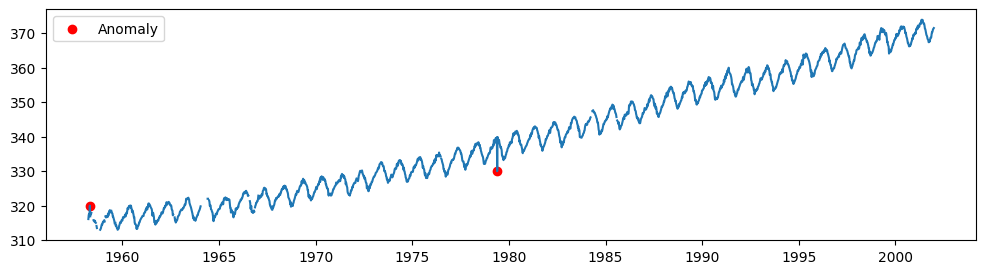

In [372]:
plt.figure(figsize=(12,3))
plt.plot(airpassengers)
plt.scatter(airpassengers.index[anomaly_idx], anomaly_value, color='red', label='Anomaly')
plt.legend()
plt.show()

In [373]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [374]:
airpassengers = airpassengers.co2.to_numpy()
airpassengers = airpassengers[~np.isnan(airpassengers), None]

In [375]:
airpassengers = airpassengers[:1000]

In [376]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(airpassengers)
normalized = scaler.transform(airpassengers)

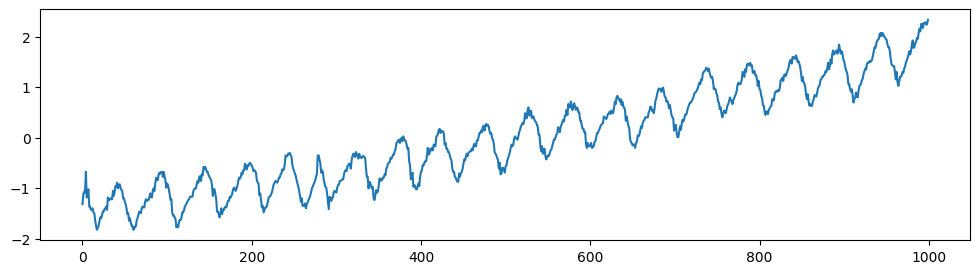

In [377]:
plt.figure(figsize=(12,3))
plt.plot(normalized)
plt.show()

In [378]:
train_size = int(len(airpassengers) * 0.8)
test_size = len(airpassengers) - train_size
train, test = airpassengers[:train_size], airpassengers[train_size:]

In [379]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([799, 1, 1]) torch.Size([799, 1, 1])
torch.Size([199, 1, 1]) torch.Size([199, 1, 1])


In [380]:
class Forecaster(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [381]:
model = Forecaster()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [382]:
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 319.3333, test RMSE 329.6407
Epoch 100: train RMSE 135.7459, test RMSE 146.0188
Epoch 200: train RMSE 4.9223, test RMSE 11.6324
Epoch 300: train RMSE 4.8174, test RMSE 10.7885
Epoch 400: train RMSE 4.8113, test RMSE 10.5183
Epoch 500: train RMSE 4.7204, test RMSE 10.9726
Epoch 600: train RMSE 4.8519, test RMSE 11.7684
Epoch 700: train RMSE 4.7268, test RMSE 11.4947
Epoch 800: train RMSE 4.1090, test RMSE 10.0496
Epoch 900: train RMSE 3.5493, test RMSE 8.7342


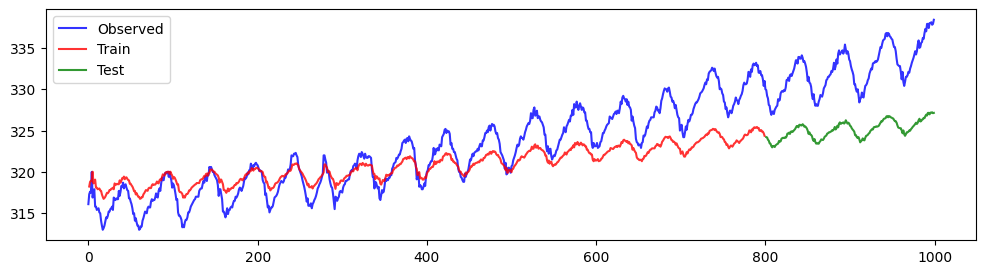

In [383]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(airpassengers) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(airpassengers) * np.nan
    test_plot[train_size+lookback:len(airpassengers)] = model(X_test)[:, -1, :]

# plot
plt.figure(figsize=(12,3))
plt.plot(airpassengers, c='b', label="Observed", alpha=.8)
plt.plot(train_plot, c='r', label="Train", alpha=.8)
plt.plot(test_plot, c='g', label="Test", alpha=.8)
plt.legend()
plt.show()

In [385]:
L2_WEIGHT = 1e-4

In [386]:
class TimeSeriesObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.mse_loss(outputs, batch[1])

    def train_regularization(self, params):
        return L2_WEIGHT * torch.square(params.norm())

    def test_loss(self, model, params, batch):
        outputs = model(batch[0])
        return F.mse_loss(outputs, batch[1])

In [387]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [388]:
train_set = data.TensorDataset(X_train, y_train)
test_set = data.TensorDataset(X_test, y_test)

In [389]:
module = CGInfluenceModule(
    model=model,
    objective=TimeSeriesObjective(),
    train_loader=data.DataLoader(train_set, batch_size=8),
    test_loader=data.DataLoader(test_set, batch_size=8),
    device=DEVICE,
    damp=0.001,
    atol=1e-8,
    maxiter=500,
)

In [390]:
test_losses = F.mse_loss(model(X_test), y_test, reduction="none")
test_idxs = torch.argsort(test_losses, dim=0, descending=False)[:5] # lower MSE better prediction
test_idxs = test_idxs.tolist()

In [391]:
helpful_time_points = []
harmful_time_points = []

all_train_idxs = list(range(X_train.shape[0]))
for test_idx in tqdm(test_idxs, desc="Computing Influences"):
    # In practice, this can be further optimized since we are recomputing the
    # loss gradients over the entire training dataset. With enough space, these
    # gradients can be cached instead.
    influences = module.influences(train_idxs=all_train_idxs, test_idxs=[test_idx[0][0]])

    helpful = influences.argmax()
    harmful = influences.argmin()

    helpful_time_points.append(helpful)
    harmful_time_points.append(harmful)

Computing Influences: 100%|███████████████████████| 5/5 [01:19<00:00, 15.84s/it]


In [392]:
harmful_time_points

[tensor(4), tensor(4), tensor(4), tensor(4), tensor(4)]

In [393]:
helpful_time_points

[tensor(788), tensor(788), tensor(788), tensor(788), tensor(788)]

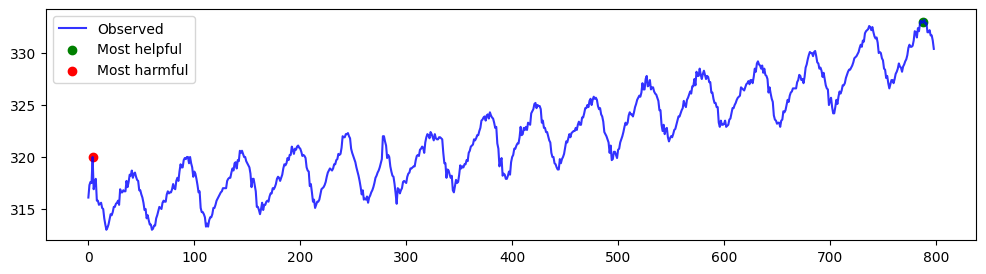

In [399]:
plt.figure(figsize=(12,3))
plt.plot(X_train.squeeze(), c='b', label="Observed", alpha=.8)
plt.scatter(helpful_time_points[0], X_train.squeeze()[helpful_time_points[0]], color='green', label='Most helpful')
plt.scatter(harmful_time_points[0], X_train.squeeze()[harmful_time_points[0]], color='red', label='Most harmful')
plt.legend()
plt.show()